# Toxicidad

In [ ]:
#Referencias:
#https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
#https://seaborn.pydata.org/generated/seaborn.pairplot.html
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/
#https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models 

In [1]:
#Libreria para nube de palabras
#!pip install wordcloud

#Instalar libreria para trabajar con datos desbalanceados
#!pip install imbalanced-learn

#Instalar la librería para visualizar el árbol
#!pip install pydotplus
#!pip install graphviz
#!pip install pydot

In [2]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import export_graphviz

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from pydotplus import graph_from_dot_data

from mpl_toolkits.mplot3d import Axes3D

from wordcloud import WordCloud

In [3]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

In [4]:
#Carga de los datos
dftrain = pd.read_csv('datos/jigsaw-unintended-bias-train.csv') 
dftrain.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
#Revisamos las variables 
dftrain.count()

id                                     1902194
comment_text                           1902194
toxic                                  1902194
severe_toxicity                        1902194
obscene                                1902194
identity_attack                        1902194
insult                                 1902194
threat                                 1902194
asian                                   426707
atheist                                 426707
bisexual                                426707
black                                   426707
buddhist                                426707
christian                               426707
female                                  426707
heterosexual                            426707
hindu                                   426707
homosexual_gay_or_lesbian               426707
intellectual_or_learning_disability     426707
jewish                                  426707
latino                                  426707
male         

In [6]:
#Seleccionamos las variables que nos interesan
col = ['comment_text','toxic','severe_toxicity','obscene','identity_attack','insult','threat']
dftrain = dftrain[col]
dftrain = dftrain[pd.notnull(dftrain['comment_text'])]
dftrain.head()

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0


In [7]:
#Describimos las variables que nos interesan
dftrain.describe()

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
count,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06
mean,1.030068e-01,4.585531e-03,1.388516e-02,2.259572e-02,8.117227e-02,9.298498e-03
std,1.970813e-01,2.286902e-02,6.465998e-02,7.863447e-02,1.760987e-01,4.939469e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


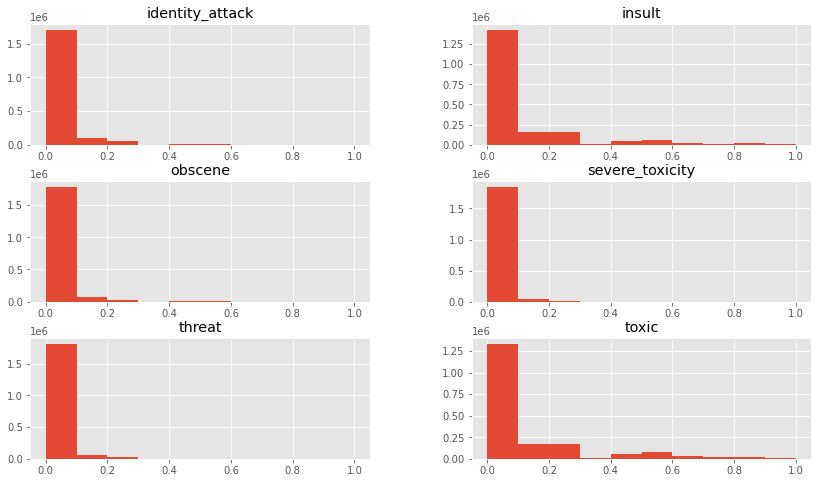

In [8]:
#Veamos graficamente los datos para tener una idea de la dispersión de los mismos
dftrain.hist()
plt.show()

In [9]:
#Calculamos el grado de toxicidad para ver la distribución de los comentarios tóxicos
dftrain['toxicidad'] = dftrain['toxic'].round(1).factorize(sort=True)[0]
toxicidad_id_df = dftrain[['toxic', 'toxicidad']].drop_duplicates().sort_values('toxicidad')
toxicidad_to_id = dict(toxicidad_id_df.values)
id_to_category = dict(toxicidad_id_df[['toxicidad', 'toxic']].values)
dftrain.head()

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,9


In [10]:
#Comentarios mas tóxicos
dftrain.loc[dftrain.toxicidad == 10]

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
289,You're an idiot.,0.968750,0.031250,0.062500,0.000000,0.968750,0.000000,10
714,Where do you get the Sour Grapes to say this i...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,10
767,Dear world:\nJust a reminder that none of thes...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
2521,F u c k the homeless. The people giving handou...,0.973006,0.261350,0.942331,0.118405,0.722086,0.719018,10
2551,The Liars Anonymous meeting today will be at 4...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
...,...,...,...,...,...,...,...,...
1900532,Trudeau speaks out of both sides of his face. ...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
1901502,Any destruction of Alaska's Grand Nature by th...,1.000000,0.200000,0.000000,0.000000,1.000000,0.000000,10
1901605,And if an employee cannot live on the offered ...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10
1902098,Good lord it looks like mr. zipper plat is bei...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10


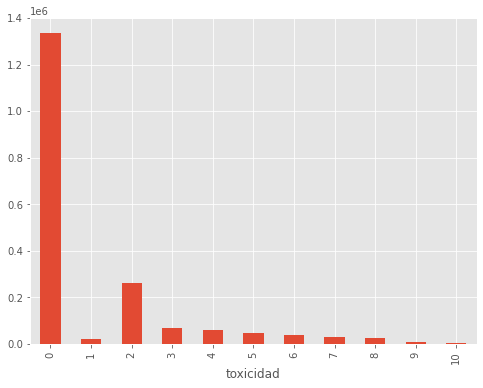

In [11]:
#Comentarios por grado de toxicidad
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dftrain.groupby('toxicidad').comment_text.count().plot.bar(ylim=0)
plt.show()

In [12]:
dftrain.groupby('toxicidad').comment_text.count()

toxicidad
0     1333804
1       22935
2      262812
3       67112
4       59536
5       48428
6       38387
7       28707
8       25765
9        9359
10       5349
Name: comment_text, dtype: int64

In [13]:
#Revision de comentarios mas tóxicos
dftoxico = dftrain.loc[dftrain.toxicidad == 10]
dftoxico.comment_text

289                                         You're an idiot.
714        Where do you get the Sour Grapes to say this i...
767        Dear world:\nJust a reminder that none of thes...
2521       F u c k the homeless. The people giving handou...
2551       The Liars Anonymous meeting today will be at 4...
                                 ...                        
1900532    Trudeau speaks out of both sides of his face. ...
1901502    Any destruction of Alaska's Grand Nature by th...
1901605    And if an employee cannot live on the offered ...
1902098    Good lord it looks like mr. zipper plat is bei...
1902179    Well the Dumper Post has a Indian idiot writin...
Name: comment_text, Length: 5349, dtype: object

(-0.5, 399.5, 199.5, -0.5)

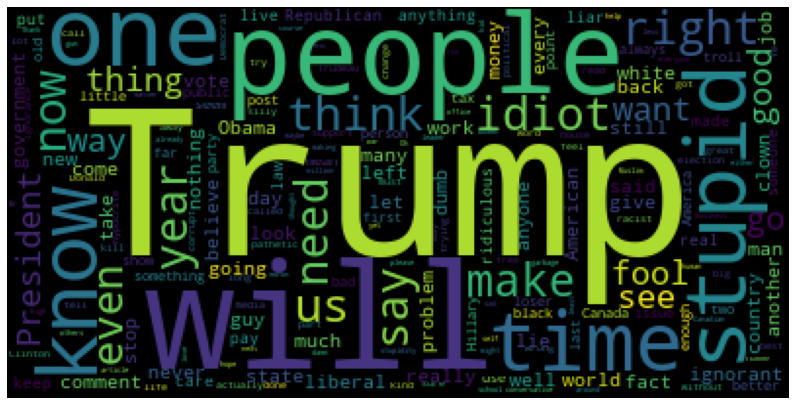

In [14]:
#Revisar las palabras que mas aparecen en los comentarios más tóxicos
#Codigo adaptado de https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models 
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

# Generar la word cloud 
text = ' '.join([nonan(comentario) for comentario in dftoxico["comment_text"]])
wordcloud = WordCloud(max_font_size=None, collocations=False).generate(text)

# Visualizar la wordcloud 
plt.imshow(wordcloud)
plt.axis("off")

### Implementación del modelo no supervizado. Utilizamos kmeans, revisando primero el k óptimo.

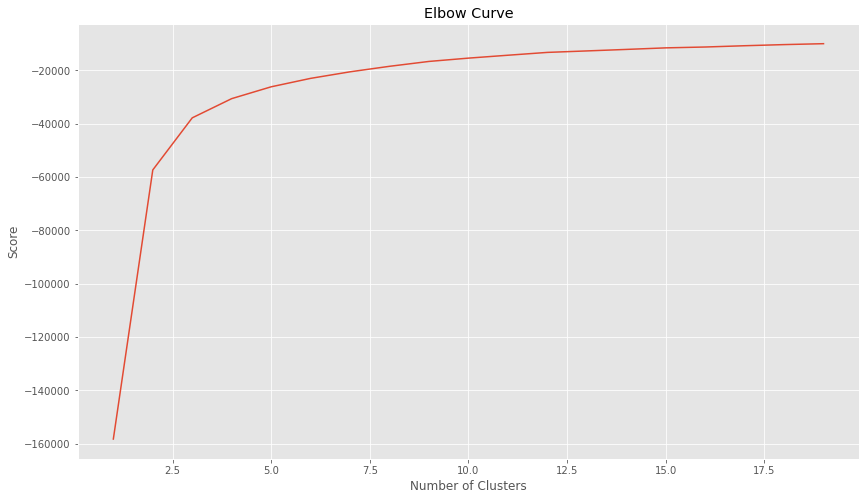

In [15]:
#Usamos kmeans porque las variables son numéricas, ya están estandarizadas, tienen el mismo tipo de medida.
#Revisamos el k óptimo
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train = dftrain[col]

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#### Vemos que mas o menos entre 3 y 5 está el punto de quiebre

In [16]:
#Realizamos una clusterización con k-medias = 3 
n_clusters = 3
clustering = cluster.KMeans(n_clusters=n_clusters)

In [17]:
#Sacamos el set de datos para el entrenamiento
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train_cluster = dftrain[col]
X_train_cluster

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.893617,0.021277,0.0,0.021277,0.872340,0.0
...,...,...,...,...,...,...
1902189,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1902190,0.166667,0.000000,0.0,0.166667,0.166667,0.0
1902191,0.400000,0.000000,0.0,0.100000,0.400000,0.0
1902192,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [18]:
#Entrenamos el modelo 
clustering.fit(X_train_cluster)

KMeans(n_clusters=3)

In [19]:
#Realizamos la predicción de las clases
y_pred_cluster = clustering.predict(X_train_cluster)
y_pred_cluster

array([0, 0, 0, ..., 2, 0, 0])

El resultado es un array de enteros de la misma logitud del número de muestras en el dataset de entrenamiento.

Los elementos en el array indican a cual grupo pertenece desde 0 hasta (tamañoDeLaMuestra-1)

In [20]:
#Escribimos el resultado en el dataset
X_train_cluster['toxicidad'] = y_pred_cluster
X_train_cluster

c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,toxic,severe_toxicity,obscene,identity_attack,insult,threat,toxicidad
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
4,0.893617,0.021277,0.0,0.021277,0.872340,0.0,1
...,...,...,...,...,...,...,...
1902189,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
1902190,0.166667,0.000000,0.0,0.166667,0.166667,0.0,2
1902191,0.400000,0.000000,0.0,0.100000,0.400000,0.0,2
1902192,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0


In [21]:
#Ver cantidades por clase
print(X_train_cluster.groupby('toxicidad').size())

toxicidad
0    1415380
1     141275
2     345539
dtype: int64


In [22]:
X_clase1 = X_train_cluster[ X_train_cluster['toxicidad']==0 ][['toxic','severe_toxicity']]
X_clase2 = X_train_cluster[ X_train_cluster['toxicidad']==1 ][['toxic','severe_toxicity']]
X_clase3 = X_train_cluster[ X_train_cluster['toxicidad']==2 ][['toxic','severe_toxicity']]

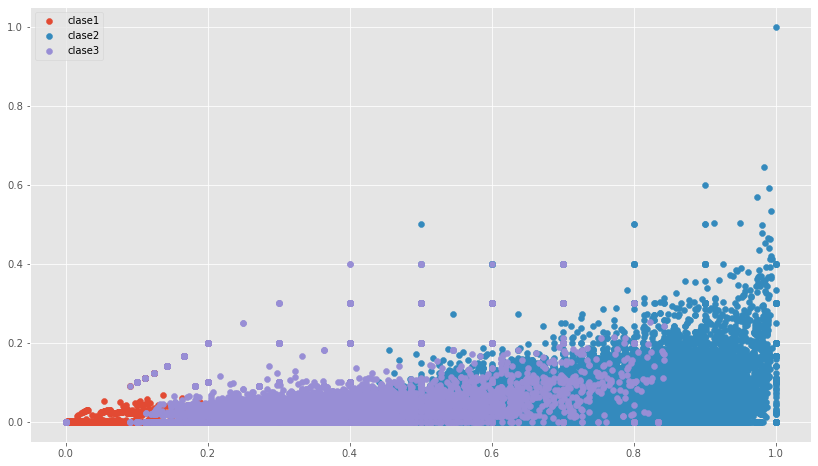

In [23]:
#Veamos una grafica de las clases
plt.scatter(X_clase1['toxic'], X_clase1['severe_toxicity'])
plt.scatter(X_clase2['toxic'], X_clase2['severe_toxicity'])
plt.scatter(X_clase3['toxic'], X_clase3['severe_toxicity'])
plt.legend(('clase1', 'clase2', 'clase3'))

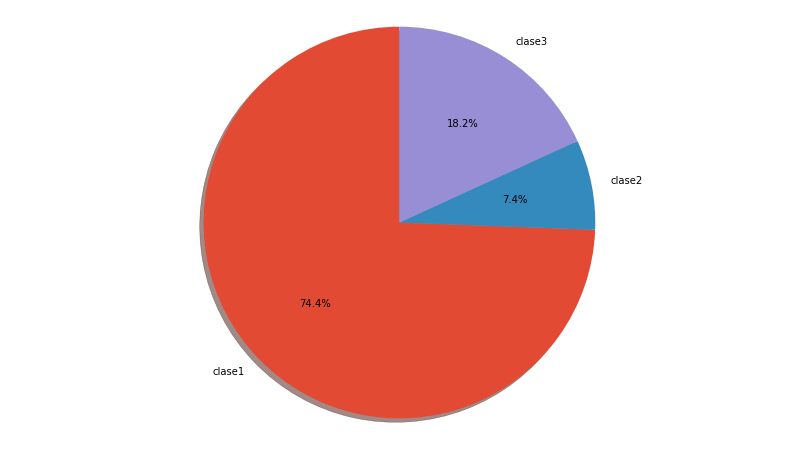

In [24]:
#Distribución de las clases
labels = 'clase1', 'clase2', 'clase3'
sizes = X_train_cluster.groupby('toxicidad').size().values
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [25]:
centers = clustering.cluster_centers_
centers = pd.DataFrame(centers)
centers.columns = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
centers

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,0.009243,0.000511,0.001369,0.003360,0.001678,0.002821
1,0.662352,0.029689,0.116835,0.099320,0.597788,0.030718
2,0.258556,0.011017,0.023084,0.070058,0.195713,0.027088


In [26]:
#Revisamos el perfilamiento de las clases, sacando los centroides de cada cluster.
centers = centers.transpose()
centers.columns = ['Clase 1','Clase 2','Clase 3']
centers

,Clase 1,Clase 2,Clase 3
toxic,0.009243,0.662352,0.258556
severe_toxicity,0.000511,0.029689,0.011017
obscene,0.001369,0.116835,0.023084
identity_attack,0.003360,0.099320,0.070058
insult,0.001678,0.597788,0.195713
threat,0.002821,0.030718,0.027088


In [27]:
#Reseteamos el set de datos, para revisar el modelo con k=5
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_train = dftrain[col]
X_train

,toxic,severe_toxicity,obscene,identity_attack,insult,threat
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.893617,0.021277,0.0,0.021277,0.872340,0.0
...,...,...,...,...,...,...
1902189,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1902190,0.166667,0.000000,0.0,0.166667,0.166667,0.0
1902191,0.400000,0.000000,0.0,0.100000,0.400000,0.0
1902192,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [28]:
#Realizamos una clusterización con k-medias = 5 para saber posibles agrupaciones
n_clusters = 5
clustering = cluster.KMeans(n_clusters=n_clusters)
clustering.fit(X_train)
y_pred = clustering.predict(X_train)
X_train['toxicidad'] = y_pred

c:\users\lflores\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


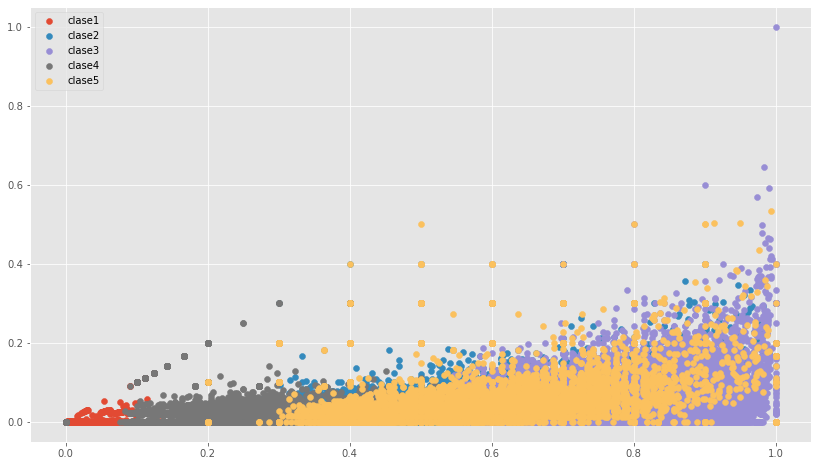

In [29]:
X_clase1 = X_train[ X_train['toxicidad']==0 ][['toxic','severe_toxicity']]
X_clase2 = X_train[ X_train['toxicidad']==1 ][['toxic','severe_toxicity']]
X_clase3 = X_train[ X_train['toxicidad']==2 ][['toxic','severe_toxicity']]
X_clase4 = X_train[ X_train['toxicidad']==3 ][['toxic','severe_toxicity']]
X_clase5 = X_train[ X_train['toxicidad']==4 ][['toxic','severe_toxicity']]

plt.scatter(X_clase1['toxic'], X_clase1['severe_toxicity'])
plt.scatter(X_clase2['toxic'], X_clase2['severe_toxicity'])
plt.scatter(X_clase3['toxic'], X_clase3['severe_toxicity'])
plt.scatter(X_clase4['toxic'], X_clase4['severe_toxicity'])
plt.scatter(X_clase5['toxic'], X_clase5['severe_toxicity'])
plt.legend(('clase1', 'clase2', 'clase3', 'clase4', 'clase5'))

# Modelo de clasificación

In [30]:
col = ['toxic','severe_toxicity','obscene','identity_attack','insult','threat']
X_class = X_train_cluster[col]
y_class = X_train_cluster['toxicidad']

#Calcular la muestra de entrenamiento y comprobación al 70%
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_class, y_class, train_size=0.7)

In [31]:
#Función para evaluar la suma de cuadrados, para ver que tan bueno es el ajuste 
def SSE(residuo):
    return np.sum(residuo**2)

In [32]:
#Función para visualizar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(3, 3))
    sb.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Matriz de Confusion")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Regresión logística

In [33]:
#Obtener el numero condición de nuestros datos de entrenamiento
matriz = np.asmatrix(X_train)
np.linalg.cond(matriz)

14.918214063687268

El número condición nos indica que el sistema de ecuaciones tiene inversa y por lo tanto, tiene solución.

In [34]:
LRmodel = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",multi_class="multinomial")
resultLRmodel = LRmodel.fit(X_train, y_train)
resultLRmodel

LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')

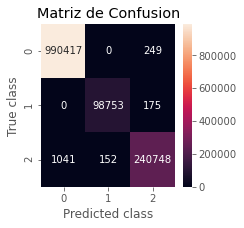

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    990666
           1       1.00      1.00      1.00     98928
           2       1.00      1.00      1.00    241941

    accuracy                           1.00   1331535
   macro avg       1.00      1.00      1.00   1331535
weighted avg       1.00      1.00      1.00   1331535



In [35]:
pred_yLRtrain = LRmodel.predict(X_train)
mostrar_resultados(y_train, pred_yLRtrain)

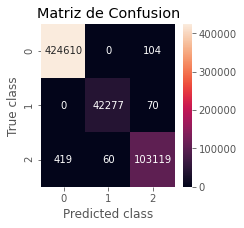

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424714
           1       1.00      1.00      1.00     42347
           2       1.00      1.00      1.00    103598

    accuracy                           1.00    570659
   macro avg       1.00      1.00      1.00    570659
weighted avg       1.00      1.00      1.00    570659



In [36]:
pred_yLR = LRmodel.predict(X_test)
mostrar_resultados(y_test, pred_yLR)

Los porcentajes de eficiencia del modelo se mantienen en ambas muestras de entrenamiento y prueba.

In [37]:
resultLRmodel.intercept_

array([ 27.3667282 , -35.465514  ,   8.09878579])

In [38]:
resultLRmodel.coef_

array([[-68.47492727,  -5.6386444 , -10.51446126, -19.25041834,
        -62.79580188,  -7.35967193],
       [ 59.68042886,   3.30608765,   9.84799589,  10.40747352,
         56.02506295,   3.59567201],
       [  8.79449841,   2.33255675,   0.66646537,   8.84294482,
          6.77073893,   3.76399992]])

In [39]:
residuo_del_entrenamiento = y_train - LRmodel.predict(X_train)
sse_train = SSE(residuo_del_entrenamiento)
sse_train

5487

In [40]:
residuo_del_testeo = y_test - LRmodel.predict(X_test)
sse_train = SSE(residuo_del_testeo)
sse_train

2222

Se obtienen residuos relativamente bajos

In [41]:
#Verificamos si el modelo está sobreajustado
print('Score para entrenamiento :' ,LRmodel.score(X_train, y_train), ' y testeo: ',LRmodel.score(X_test, pred_yLR))

Score para entrenamiento : 0.9987856120943122  y testeo:  1.0


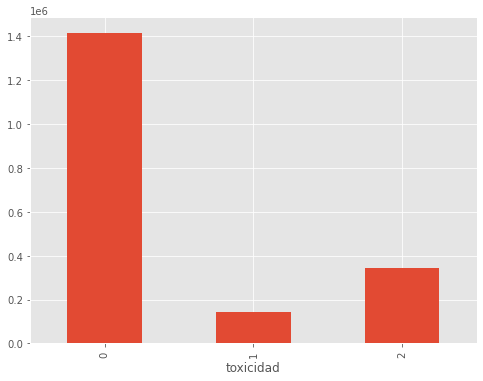

In [42]:
#Revisamos si hay desbalanceo de las clases
fig = plt.figure(figsize=(8,6))
X_train_cluster.groupby('toxicidad').toxic.count().plot.bar(ylim=0)
plt.show()

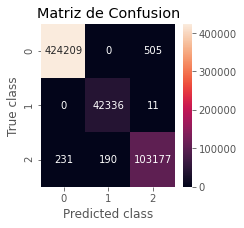

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424714
           1       1.00      1.00      1.00     42347
           2       1.00      1.00      1.00    103598

    accuracy                           1.00    570659
   macro avg       1.00      1.00      1.00    570659
weighted avg       1.00      1.00      1.00    570659



In [43]:
#Regresión logistica con balanceo
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in
#the input data as n_samples / (n_classes * np.bincount(y)).
#Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

balancedRLmodel = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",multi_class="multinomial",class_weight="balanced")
balancedRLmodel.fit(X_train, y_train)
 
pred_ybalancedRL = balancedRLmodel.predict(X_test)
mostrar_resultados(y_test, pred_ybalancedRL)

## Arbol de decision

In [44]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

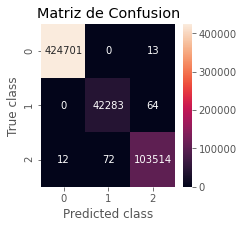

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424714
           1       1.00      1.00      1.00     42347
           2       1.00      1.00      1.00    103598

    accuracy                           1.00    570659
   macro avg       1.00      1.00      1.00    570659
weighted avg       1.00      1.00      1.00    570659



In [45]:
y_test_predTree = classifier.predict(X_test)
mostrar_resultados(y_test, y_test_predTree)

In [46]:
with open(r"tree2.dot", 'w') as f:
     f = tree.export_graphviz(classifier,
                              out_file=f,                              
                              impurity = True,
                              feature_names = list(col),
                              class_names = ['Bajo', 'Medio','Alto'],
                              rounded = True,
                              filled= True )
        

In [47]:
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng','tree2.dot','-o','tree3.png'])

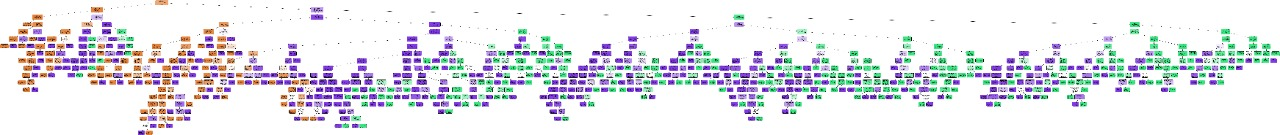

In [48]:
PImage("tree3.png")

## Evaluación de los modelos

In [49]:
#Definir una metrica basada en Rogers y Tanimoto (1960)
def obtener_eficiencia(pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    
    traza = np.trace(conf_matrix)
    total = np.sum(conf_matrix)
    
    eficiencia = traza / ((total-traza)*2 + traza) #castigamos lo que está por fuera de la diagonal
    return eficiencia   

In [50]:
#Eficiencia de los modelos
print("Regresión logística: ",obtener_eficiencia(pred_yLR))
print("Regresión logística con balanceo: ",obtener_eficiencia(pred_ybalancedRL))
print("Regresión árbol de decision: ",obtener_eficiencia(y_test_predTree))

Regresión logística:  0.9977140336628673
Regresión logística con balanceo:  0.9967214606120407
Regresión árbol de decision:  0.9994358992326828


Podemos concluir que el mejor modelo es el árbol de decision.

In [51]:
#Guardamos el modelo clasificador para posterior uso
pickle.dump( LRmodel, open( "clasificadorRLToxicidad.pkl", "wb" ) )
pickle.dump( classifier, open( "clasificadorArbolToxicidad.pkl", "wb" ) )